- https://stackabuse.com/python-for-nlp-developing-an-automatic-text-filler-using-n-grams/
- https://github.com/shotapentaho/pytorch-sentiment-analysis/blob/master/5%20-%20Multi-class%20Sentiment%20Analysis.ipynb
- https://github.com/keitakurita/practical-torchtext/blob/master/Lesson%201%20intro%20to%20torchtext%20with%20text%20classification.ipynb

In [125]:
from numpy import array
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import re
import tqdm
import matplotlib.pyplot as plt

import torch
from torchtext import data

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext


In [2]:
#Dataset can be downloaded from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview

toxic_comments = pd.read_csv("data/toxic_comments.csv")

In [3]:
print(toxic_comments.shape)

toxic_comments.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [5]:
print(toxic_comments.shape)

(159571, 8)


In [6]:
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [7]:
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [8]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


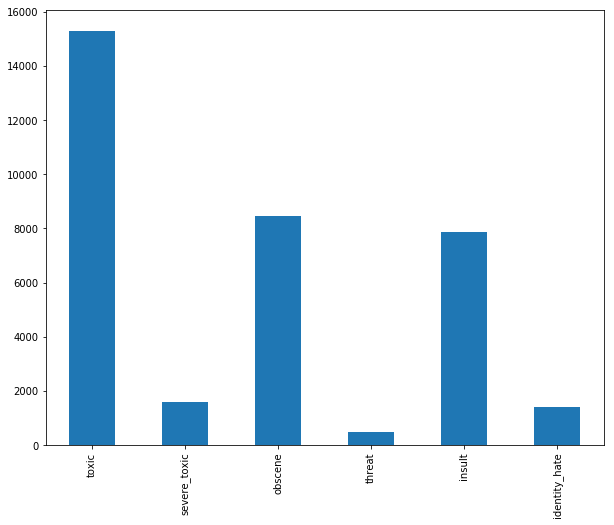

In [9]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [10]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [11]:
# X = []
# sentences = list(toxic_comments["comment_text"])
# for sen in sentences:
#     X.append(preprocess_text(sen))

# y = toxic_comments_labels.values

In [12]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [13]:
train, valid, test = train_validate_test_split(toxic_comments)


In [14]:
print(toxic_comments.shape)
print(train.shape)
print(valid.shape)
print(test.shape)

(159571, 8)
(95742, 8)
(31914, 8)
(31915, 8)


In [15]:
!mkdir data/toxic_comments

mkdir: cannot create directory ‘data/toxic_comments’: File exists


In [16]:
train.to_csv("data/toxic_comments/train.csv", index=False)
valid.to_csv("data/toxic_comments/valid.csv", index=False)
test.to_csv("data/toxic_comments/test.csv", index=False)


In [17]:
import spacy
spacy_en = spacy.load('en')
# nltk.download('punkt')

In [18]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Cuda Status on system is False


In [19]:
# sample tokenizer which you can use
def tokenizer(text):
    return [tok for tok in nltk.word_tokenize(text)]

In [43]:
# tokenizer = "spacy" uses spacy's tokenizer
TEXT = data.Field(sequential=True, tokenize="spacy", lower=True)
LABEL = data.LabelField(dtype=torch.long, sequential=False, use_vocab=False)
# LABEL = Field(sequential=False, )

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
# COMMENT_TEXT = data.Field()
# TOXIC = data.Field()
# SEVERE_TOXIC = data.Field()
# OBSCENE = data.Field()
# THREAT = data.Field()
# INSULT = data.Field()
# IDENTITY_HATE = data.Field()

# create tuples representing the columns
fields = [("id", None), # we won't be needing the id, so we pass in None as the field
                 ("comment_text", TEXT), ("toxic", LABEL),
                 ("severe_toxic", LABEL), ("threat", LABEL),
                 ("obscene", LABEL), ("insult", LABEL),
                 ("identity_hate", LABEL)]

train_data, valid_data, test_data = data.TabularDataset.splits(
    path="data/toxic_comments/", train="train.csv", 
    validation="valid.csv", test="test.csv",format="csv", skip_header=True, 
#     fields=[('Text', TEXT), ('Label', LABEL)]
    fields = fields
)

In [46]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 95742
Number of valid examples: 31914
Number of testing examples: 31915


In [47]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)


In [48]:
vars(train_data[-1])

{'comment_text': ['changing',
  'images',
  '\n\n',
  'hi',
  ',',
  'why',
  'are',
  'you',
  'changing',
  'my',
  'image',
  'tags',
  '.',
  'they',
  'are',
  'fairinunse',
  ',',
  'they',
  'have',
  'a',
  'source',
  'and',
  'rationale',
  'and',
  'for',
  'some',
  'reason',
  'your',
  'deleting',
  'them',
  '.',
  'why',
  '?'],
 'toxic': '0',
 'severe_toxic': '0',
 'threat': '0',
 'obscene': '0',
 'insult': '0',
 'identity_hate': '0'}

In [49]:
TEXT.vocab.freqs.most_common(10)

[('.', 308155),
 ('the', 297317),
 (',', 283416),
 ('"', 227155),
 ('to', 178243),
 ('i', 142587),
 ('of', 134490),
 ('and', 133939),
 ('you', 131966),
 ('a', 129103)]

In [50]:
train_data.__dict__.keys()

dict_keys(['examples', 'fields'])

In [51]:
train_data[0].comment_text[:3]

['new', 'source', '\n\n']

In [52]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [53]:
batch = next(train_iterator.__iter__()); batch


[torchtext.data.batch.Batch of size 64]
	[.comment_text]:[torch.LongTensor of size 295x64]
	[.toxic]:[torch.LongTensor of size 64]
	[.severe_toxic]:[torch.LongTensor of size 64]
	[.threat]:[torch.LongTensor of size 64]
	[.obscene]:[torch.LongTensor of size 64]
	[.insult]:[torch.LongTensor of size 64]
	[.identity_hate]:[torch.LongTensor of size 64]

In [54]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'comment_text', 'toxic', 'severe_toxic', 'threat', 'obscene', 'insult', 'identity_hate'])

In [98]:
class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x and y
    
    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)
    
    def __len__(self):
        return len(self.dl)

In [100]:
train_dl = BatchWrapper(train_iterator, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
valid_dl = BatchWrapper(valid_iterator, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
test_dl = BatchWrapper(test_iterator, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])

In [114]:
next(train_dl.__iter__())

(tensor([[  201,    19,  5675,  ...,     5,   140,     5],
         [   17,    12,  2009,  ...,    25,   452,    84],
         [    7,    20,    25,  ...,    70,   511, 23162],
         ...,
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1]]),
 tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 1., 1., 0.],


In [138]:
# import torch.nn as nn
# import torch.nn.functional as F

# class FastText(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
#         super().__init__()
        
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
#         self.fc = nn.Linear(embedding_dim, output_dim)
        
#     def forward(self, text):
        
#         #text = [sent len, batch size]
        
#         embedded = self.embedding(text)
                
#         #embedded = [sent len, batch size, emb dim]
        
#         embedded = embedded.permute(1, 0, 2)
        
#         #embedded = [batch size, sent len, emb dim]
                                        
#         return self.fc(embedded)

class SimpleBiLSTMBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim=300,
                 spatial_dropout=0.05, recurrent_dropout=0.1, num_linear=1):
        super().__init__() # don't forget to call this!
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=1, dropout=recurrent_dropout)
        self.linear_layers = []
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.linear_layers = nn.ModuleList(self.linear_layers)
        self.predictor = nn.Linear(hidden_dim, 6)
    
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
            feature = layer(feature)
        preds = self.predictor(feature)
        return preds

In [139]:
len(TEXT.vocab)

25002

In [141]:
# INPUT_DIM = len(TEXT.vocab)
# EMBEDDING_DIM = 100
# OUTPUT_DIM = 6
# PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

# opt = optim.Adam(model.parameters(), lr=1e-2)
# loss_func = nn.BCEWithLogitsLoss()

em_sz = 100
nh = 500
nl = 3
model = SimpleBiLSTMBaseline(nh, emb_dim=em_sz); model

opt = optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.BCEWithLogitsLoss()

In [142]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,707,206 trainable parameters


In [129]:
# pretrained_embeddings = TEXT.vocab.vectors

# model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.7364,  1.1356, -0.0090,  ..., -1.4841,  0.4219,  0.0943],
        [ 0.3202,  1.4562, -1.4856,  ...,  0.2605, -0.1280,  0.2449],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.0441,  0.6655, -0.0255,  ..., -0.0296, -0.4612,  0.8184],
        [ 0.3466, -0.4393, -0.5898,  ...,  0.4000, -0.4355, -0.8640],
        [-0.5669,  0.7411, -0.4570,  ...,  0.1494, -0.1386, -0.0659]])

In [130]:
# UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
# model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [131]:
# import torch.optim as optim

# optimizer = optim.Adam(model.parameters())

In [132]:
# criterion = nn.BCEWithLogitsLoss()

# model = model.to(device)
# criterion = criterion.to(device)

In [133]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [134]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [135]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [136]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

epochs = 2
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() # turn on training mode
    for x, y in tqdm.tqdm(train_dl): # thanks to our wrapper, we can intuitively iterate over our data!
        opt.zero_grad()

        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        
        running_loss += loss.item() * x.size(0)
        
    epoch_loss = running_loss / len(trn)
    
    # calculate the validation loss for this epoch
    val_loss = 0.0
    model.eval() # turn on evaluation mode
    for x, y in valid_dl:
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.item() * x.size(0)

    val_loss /= len(vld)
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, epoch_loss, val_loss))


  8%|▊         | 116/1496 [27:27<2:22:10,  6.18s/it]

In [113]:
# N_EPOCHS = 2

# best_valid_loss = float('inf')

# for epoch in range(N_EPOCHS):

#     start_time = time.time()
    
#     train_loss, train_acc = train(model, train_dl, optimizer, criterion)
#     valid_loss, valid_acc = evaluate(model, valid_dl, criterion)
    
#     end_time = time.time()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         torch.save(model.state_dict(), 'tut3-model.pt')
    
#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

AttributeError: 'tuple' object has no attribute 'text'